# Scattering

## 1. Morlet Wavelet

In [1]:
%matplotlib inline
%load_ext line_profiler
from mnist import MNIST
import numpy as np
from scipy import signal, misc, ndimage
from itertools import combinations
import math
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from sklearn.decomposition import PCA



In [2]:
def Morlet2D_grid(n_lines, n_columns, J = 0, theta = 0, sigma = 0.85, xi = 3 * np.pi / 4):
    """returns 2d Morlet real and imaginary filter of size (n_lines, n_columns), rotated by theta and dilated by 1/2^J"""
    X = np.arange(-n_columns / 2**(J+1), n_columns / 2**(J+1), 1/2**J) #to get n_columns length vector
    Y = np.arange(-n_lines / 2**(J+1), n_lines / 2**(J+1), 1/2**J)
    X, Y = np.meshgrid(X, Y)
    #rotate
    X_theta = np.cos(theta) * X + np.sin(theta) * Y 
    Y_theta = np.cos(theta) * Y - np.sin(theta) * X
    
    Wave = np.exp(1j * xi * (X_theta + Y_theta))
    Z_r = np.real(Wave)
    Z_i = np.imag(Wave)
    Gaus = np.exp(-np.sqrt(X_theta**2 + Y_theta**2) / (2 * sigma**2))
    Z_r *= Gaus
    Z_i *= Gaus
    
    #center Morlet wave
    Int_r = np.sum(Z_r)
    Int_i = np.sum(Z_i)
    Int_Gaus = np.sum(Gaus)

    beta_r = Int_r / Int_Gaus
    beta_i = Int_i/ Int_Gaus
    
    Z_r -= beta_r * Gaus
    Z_i -= beta_i * Gaus
    return(Z_r + 1j * Z_i)

### Representation d'une ondelette Morlet

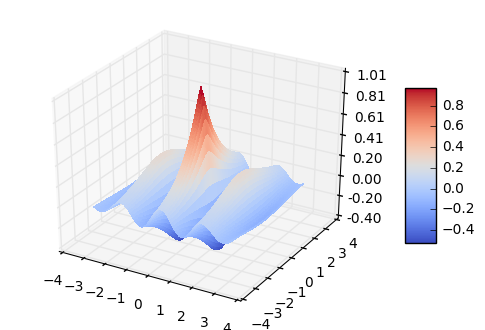

In [3]:
Z = Morlet2D_grid(100, 100, 4, theta = 3*np.pi/4)
Z_r = np.real(Z)
Z_i = np.imag(Z)
X = np.arange(-100 / 32, 100 / 32, 1/16)
Y = np.arange(-100 / 32, 100 / 32, 1/16)
X, Y = np.meshgrid(X, Y)
fig = plt.figure()
ax = fig.gca(projection='3d')
surf = ax.plot_surface(X, Y, Z_r, rstride=1, cstride=1, cmap = cm.coolwarm,
        linewidth=0, antialiased=False)
ax.set_zlim(-0.4, 1.01)


ax.zaxis.set_major_locator(LinearLocator(8))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))
fig.colorbar(surf, shrink=0.5, aspect=5)
plt.show()

## Convolution 

In [6]:

def ss_conv_2d(d1, d2, decy, decx):
    """ convolve with subsamples see : http://stackoverflow.com/questions/41857498
    /scipy-convolve2d-with-subsampling-like-theanos-conv2d"""
    ny = d1.shape[0] // decy
    nx = d1.shape[1] // decx
    out = np.zeros((ny, nx))
    d1_p = d1[ : ny * decy, : nx * decx]
    d2_p = d2[ : ny * decy, : nx * decx]
    for i in range(decy):
        for j in range(decx):
            d1d = d1_p[i::decy, j::decx]
            d2d = d2_p[decy-i-1::decy, decx-j-1::decx]
            cv = signal.convolve2d(d1d, d2d, 'same')
            out[:cv.shape[0], :cv.shape[1]] += cv
    return out

In [8]:
def morl_conv(image, subsample = 1, J = 0, theta = 0, sigma = 0.85, xi = 3 * np.pi / 4):
    
    """image of shape (n_lines, n_columns) (levels of grey not RGB), returns convolution with Morlet2D_grid"""
    morlet_filter = Morlet2D_grid(image.shape[0], image.shape[1], J, theta, sigma, xi)
    return (signal.fftconvolve(image, morlet_filter, mode = "same")[ :: subsample,  ::subsample])

In [9]:
def morl_conv2(image, subsample = 1, J = 0, theta = 0, sigma = 0.85, xi = 3 * np.pi / 4):
    """image of shape (n_lines, n_columns) (levels of grey not RGB), returns convolution with Morlet2D_grid"""
    morlet_filter = Morlet2D_grid(image.shape[0], image.shape[1], J, theta, sigma, xi)
    return (ss_conv_2d(image, np.real(morlet_filter), subsample, subsample) ++ 1j*ss_conv_2d(image, np.imag(morlet_filter), subsample, subsample))

In [10]:
mndata = MNIST('/home/sel/Desktop/cours ENSAE/TensorFlow/MNIST-data')

In [11]:
mnist_images = mndata.load_training()


In [12]:
train_set = []
label_set = []
sample_size = 400
for i in range(sample_size):
    train_set.append(np.array(mnist_images[0][i]).reshape(28,28))
    label_set.append(mnist_images[1][i])

In [13]:
f = np.array(mnist_images[0][0]).reshape(28,28)
print(mnist_images[1][0])

5


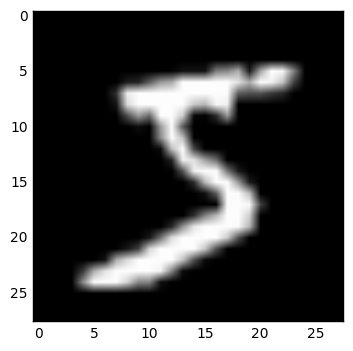

In [14]:
plt.imshow(f, cmap=plt.cm.gray)

(9, 9)
(10, 10)
False
<class 'numpy.complex128'> <class 'numpy.complex128'>
[  28.69442435  -6.63568699j  -10.47460928 -79.11047186j
 -216.44352727 -28.32570629j -108.13068162+313.82573649j
   68.35939585+124.93107482j -137.74158302+172.9300076j
   95.68663976 +68.78727547j   62.97738118-155.89258556j
  -73.26379669-128.21967879j]
[   4.85549029 -19.8148741j   -54.41567173 -22.73022742j
 -111.66805861+125.39292673j  238.58276582+318.61118787j
  269.28234418 +54.35399504j  112.46725763+203.63291529j
  195.00202046 -22.97472567j -208.84414640-133.86014552j
 -243.34286119 +39.33597833j  -46.52437341+103.6216432j ]


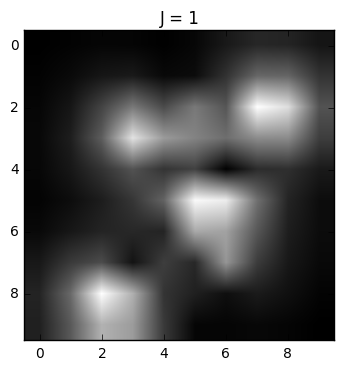

In [15]:
fig = plt.figure()
a = fig.add_subplot(1, 1, 1)
f2 = morl_conv(f,subsample = 3, J = 1, theta = np.pi/3)
f3 = morl_conv2(f, subsample = 3, J = 1, theta = np.pi/3)
print(f3.shape)
print(f2.shape)
print(f3[1][0] == f2[1][0])
print(type(f3[1][0]), type(f2[1][0]))
print(f3[3])
print(f2[3])
f2 = np.abs(f2)
plt.imshow(f2, cmap = plt.cm.gray)
a.set_title("J = 1")

[  8.16322385  13.04842356  19.21730704  18.24431661  12.48674747
  23.06956543  54.53716191  82.65906675  79.52859975  53.07718128]
[  6.98632416  11.53983694  17.14592149  15.07382414   9.03542964
  19.53178043  50.20298843  74.53323112  70.79457986  43.83147559]


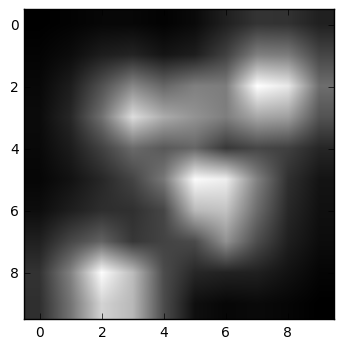

In [16]:
f3 = ndimage.filters.gaussian_filter(f2, 1/2)
plt.imshow(f3, cmap = plt.cm.gray)
print(f3[0, :])
print(f2[0, :])

## Computing Scattering coeffs

In [17]:
def cascade_wavelet_transf(image, j_path, theta_path):
    """js_path is the dilatations 2**-j we want to compute, thetas_path is similarly thetas path for the rotations 
    returns U[p]: see Mallat article """
    U = image.copy()
    for j, theta in zip(j_path, theta_path):
        U = np.abs(morl_conv(U, J = j, theta = theta))
    return U
        
            

In [18]:
def scattering_paths(J, m, K):
    """ returns a list of all paths = [(j_path, theta_path)] of length M with j_path[k]<j_path[k+1]<= J
        and theta = 2 * np.pi * k, k < K"""
    thetas = [2 * np.pi * k / K for k in range(K)]
    js_path = [list(comb) for comb in combinations(range(1, J + 1), m)]
    thetas_paths = [[theta] for theta in thetas]
    scat_path = []
    for i in range(m - 1):
        new_th_paths = []
        for j in range(len(thetas_paths)):
            for theta in thetas:
                new_th_paths.append(thetas_paths[j] + [theta])
        thetas_paths = new_th_paths
    for j_path in js_path:
        for th_path in thetas_paths:
            scat_path.append((j_path, th_path))
    return scat_path

In [19]:
def scatter_coeffs_long(image, m, K, J = 0, alpha = 1/2):
    
    """J = number of dilatations, m = length of the scattering conv network, K = number of rotations
    too long"""
    if J == 0:
        J = int(math.log(image.shape[0], 2))
    print(J)
    scat_coeffs = {}
    for i in range(1, m + 1):
        scat_coeffs[i] = []
        for path in scattering_paths(J, i, K):
            U_path = cascade_wavelet_transf(image, path[0], path[1])
            S_U_path = 1/2**J*ndimage.filters.gaussian_filter(U_path, 1/2**J)
            scat_coeffs[i].append(S_U_path) #vérifier que c'est toujous les mêmes
    print(len(scat_coeffs[1]), len(scat_coeffs[2]))
    return scat_coeffs
            

In [22]:
def continue_path(path, J, K):
    """gets a scattering path of length m, outputs a list of all paths of length m+1 that you could obtain from this path"""
    cont_paths = []
    
    if type(path[0]) == int:#du au fait qu'un tuple ne peut pas avoir une longueur de 1
        j_m = path[0]
    else:
        j_m = path[-1][0]
    thetas = [2 * np.pi * k / K for k in range(K)]
    for j in range(j_m + 1, J + 1):
        for theta in thetas:
            if type(path[0]) == int:
                path1 = [path]
            else:
                path1 = list(path)
            path1 += [(j, theta)]
            cont_paths.append(tuple(path1))
    return cont_paths

continue_path(((1,2),(2, 3*np.pi)), 5, 3)

[((1, 2), (2, 9.42477796076938), (3, 0.0)),
 ((1, 2), (2, 9.42477796076938), (3, 2.0943951023931953)),
 ((1, 2), (2, 9.42477796076938), (3, 4.1887902047863905)),
 ((1, 2), (2, 9.42477796076938), (4, 0.0)),
 ((1, 2), (2, 9.42477796076938), (4, 2.0943951023931953)),
 ((1, 2), (2, 9.42477796076938), (4, 4.1887902047863905)),
 ((1, 2), (2, 9.42477796076938), (5, 0.0)),
 ((1, 2), (2, 9.42477796076938), (5, 2.0943951023931953)),
 ((1, 2), (2, 9.42477796076938), (5, 4.1887902047863905))]

In [20]:
def scatter_coeffs_fast(image, m, K, J = 0, alpha = 1/2):
    """J = number of dilatations, m = length of the scattering conv network, K = number of rotations"""
    if J == 0 :
        J = int(math.log(image.shape[0], 2))
    scat_coeffs = []
    paths = []
    U_p = {1 : {}}
    for j in range(1, J +1):
        for theta in [2 * np.pi * k / K for k in range(K)]:
            path = (j, theta)
            paths.append((path))
            U_p[1][path] = np.abs(morl_conv(image, subsample = path[0], J = path[0], theta = path[1]))
    for i in range(1, m):
        U_p[i+1] = {}
        paths2 = []
        for path in paths:
            scat_coeffs.append(1/2**J*ndimage.filters.gaussian_filter(U_p[i][path], 1/2**J)[ :: 2**J, :: 2**J])
            for next_path in continue_path(path, J, K):
                U_p[i+1][next_path] =  np.abs(morl_conv(image, subsample = next_path[-1][0], J = next_path[-1][0], theta = next_path[-1][0]))
                paths2.append(next_path)
        paths = paths2
    for path in paths:
        scat_coeffs.append(1/2**J*ndimage.filters.gaussian_filter(U_p[m][path], 1/2**J))
    return scat_coeffs

In [124]:
%lprun -f morl_conv scatter_coeffs_long(f, 3, 6)

4
24 216


In [125]:
%lprun -f morl_conv scatter_coeffs_fast(f, 3, 6)

In [23]:
Scatter_data = []
for i in range(len(train_set)):
    if i%100 == 0:
        print(i)
    Scatter_data.append(scatter_coeffs_fast(train_set[i], 3, 6))

0
100
200
300


In [24]:
for i in range(len(Scatter_data)):
    final_coeff = np.zeros(1)
    for coeff in Scatter_data[i]:
        final_coeff = np.concatenate((final_coeff, coeff.reshape(-1)))
    Scatter_data[i] = final_coeff[1 : ]

In [25]:
from sklearn.svm import SVC
clf = SVC()
clf.fit(Scatter_data, label_set)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [27]:
for j in range(100):
    label = mnist_images[1][400 + j]
    if label < 5:
        print(j)
        coeffs = scatter_coeffs_fast(np.array(mnist_images[0][400 + j]).reshape((28,28)), 3, 6)
        final_coeff = np.zeros(1)
        for coeff in coeffs:
            final_coeff = np.concatenate((final_coeff, coeff.reshape(-1)))
        final_coeff = final_coeff[1:]
        final_coeff.reshape(-1)
        print("vraie valeur: {} ".format(label), "valeur prédite : {}".format(clf.predict(final_coeff)))

0


/home/sel/.local/lib/python3.5/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


vraie valeur: 2  valeur prédite : [1]
2


/home/sel/.local/lib/python3.5/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


vraie valeur: 4  valeur prédite : [1]
5


/home/sel/.local/lib/python3.5/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


vraie valeur: 3  valeur prédite : [1]
6


/home/sel/.local/lib/python3.5/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


vraie valeur: 1  valeur prédite : [1]
8


/home/sel/.local/lib/python3.5/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


vraie valeur: 1  valeur prédite : [1]
10


/home/sel/.local/lib/python3.5/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


vraie valeur: 2  valeur prédite : [1]
12


/home/sel/.local/lib/python3.5/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


vraie valeur: 4  valeur prédite : [1]
13


/home/sel/.local/lib/python3.5/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


vraie valeur: 4  valeur prédite : [1]
14


/home/sel/.local/lib/python3.5/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


vraie valeur: 4  valeur prédite : [1]
16


/home/sel/.local/lib/python3.5/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


vraie valeur: 1  valeur prédite : [1]
25


/home/sel/.local/lib/python3.5/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


vraie valeur: 3  valeur prédite : [1]
27


/home/sel/.local/lib/python3.5/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


vraie valeur: 0  valeur prédite : [1]
29


/home/sel/.local/lib/python3.5/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


vraie valeur: 0  valeur prédite : [1]
32


/home/sel/.local/lib/python3.5/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


vraie valeur: 2  valeur prédite : [1]
33


/home/sel/.local/lib/python3.5/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


vraie valeur: 3  valeur prédite : [1]
35


/home/sel/.local/lib/python3.5/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


vraie valeur: 0  valeur prédite : [1]
38


/home/sel/.local/lib/python3.5/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


vraie valeur: 4  valeur prédite : [1]
40


/home/sel/.local/lib/python3.5/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


vraie valeur: 0  valeur prédite : [1]
42


/home/sel/.local/lib/python3.5/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


vraie valeur: 4  valeur prédite : [1]
43


/home/sel/.local/lib/python3.5/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


vraie valeur: 1  valeur prédite : [1]
44


/home/sel/.local/lib/python3.5/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


vraie valeur: 2  valeur prédite : [1]
47


/home/sel/.local/lib/python3.5/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


vraie valeur: 1  valeur prédite : [1]
48


/home/sel/.local/lib/python3.5/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


vraie valeur: 2  valeur prédite : [1]
50


/home/sel/.local/lib/python3.5/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


vraie valeur: 1  valeur prédite : [1]
51


/home/sel/.local/lib/python3.5/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


vraie valeur: 0  valeur prédite : [1]
52


/home/sel/.local/lib/python3.5/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


vraie valeur: 3  valeur prédite : [1]
53


/home/sel/.local/lib/python3.5/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


vraie valeur: 0  valeur prédite : [1]
54


/home/sel/.local/lib/python3.5/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


vraie valeur: 1  valeur prédite : [1]
55


/home/sel/.local/lib/python3.5/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


vraie valeur: 1  valeur prédite : [1]
57


/home/sel/.local/lib/python3.5/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


vraie valeur: 2  valeur prédite : [1]
58


/home/sel/.local/lib/python3.5/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


vraie valeur: 0  valeur prédite : [1]
59


/home/sel/.local/lib/python3.5/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


vraie valeur: 3  valeur prédite : [1]
61


/home/sel/.local/lib/python3.5/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


vraie valeur: 4  valeur prédite : [1]
62


/home/sel/.local/lib/python3.5/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


vraie valeur: 0  valeur prédite : [1]
64


/home/sel/.local/lib/python3.5/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


vraie valeur: 0  valeur prédite : [1]
66


/home/sel/.local/lib/python3.5/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


vraie valeur: 1  valeur prédite : [1]
70


/home/sel/.local/lib/python3.5/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


vraie valeur: 1  valeur prédite : [1]
72


/home/sel/.local/lib/python3.5/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


vraie valeur: 2  valeur prédite : [1]
73


/home/sel/.local/lib/python3.5/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


vraie valeur: 0  valeur prédite : [1]
75


/home/sel/.local/lib/python3.5/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


vraie valeur: 1  valeur prédite : [1]
76


/home/sel/.local/lib/python3.5/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


vraie valeur: 2  valeur prédite : [1]
77


/home/sel/.local/lib/python3.5/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


vraie valeur: 2  valeur prédite : [1]
79


/home/sel/.local/lib/python3.5/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


vraie valeur: 3  valeur prédite : [1]
81


/home/sel/.local/lib/python3.5/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


vraie valeur: 4  valeur prédite : [1]
84


/home/sel/.local/lib/python3.5/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


vraie valeur: 1  valeur prédite : [1]
86


/home/sel/.local/lib/python3.5/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


vraie valeur: 3  valeur prédite : [1]
89


/home/sel/.local/lib/python3.5/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


vraie valeur: 0  valeur prédite : [1]
90


/home/sel/.local/lib/python3.5/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


vraie valeur: 3  valeur prédite : [1]
91


/home/sel/.local/lib/python3.5/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


vraie valeur: 1  valeur prédite : [1]
92


/home/sel/.local/lib/python3.5/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


vraie valeur: 1  valeur prédite : [1]
93


/home/sel/.local/lib/python3.5/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


vraie valeur: 2  valeur prédite : [1]
95
vraie valeur: 3  valeur prédite : [1]


/home/sel/.local/lib/python3.5/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


In [144]:
len(Scatter_data[0])

1104

In [145]:
sc_data = {i: [] for i in range(10)}

In [146]:
for i in range(len(Scatter_data)):
    sc_data[label_set[i]].append(Scatter_data[i])

In [147]:
print(len(sc_data[0][0][0][0]))

2


In [152]:
for i in range(10):
    print(len(sc_data[i]))
for i in range(10):
    for j in range(len(sc_data[i])):
        final_coeff = np.zeros(1)
        for coeff in sc_data[i][j]:
            final_coeff = np.concatenate((final_coeff, coeff.reshape(-1)))
        sc_data[i][j] = final_coeff[1:]
print(sc_data[3][0].shape, type((sc_data[1][0][0])))

39
52
42
41
44
30
36
42
30
44
(53610,) <class 'numpy.float64'>


In [153]:
print(sc_data[5][0].shape, type((sc_data[1][0][0])))

(53610,) <class 'numpy.float64'>


In [154]:
del Scatter_data

In [155]:
pca = PCA(n_components=23)

In [156]:
zero_new = pca.fit_transform(np.array(sc_data[0]))

In [170]:
pcas = {}
for i in range(5):
    print(i)
    pcas[i] = PCA(n_components = 3)
    pcas[i].fit(sc_data[i])

0
1
2
3
4


In [171]:
predictions = {i : [0,0] for i in range(5)}

for j in range(100):
    label = mnist_images[1][400 + j]
    if label < 5:
        predictions[label][1] +=1
        print(j)
        coeffs = scatter_coeffs_fast(np.array(mnist_images[0][400 + j]).reshape((28,28)), 3, 6)
        final_coeff = np.zeros(1)
        for coeff in coeffs:
            final_coeff = np.concatenate((final_coeff, coeff.reshape(-1)))
        final_coeff = final_coeff[1:]
        final_coeff.reshape(-1)
        pred_label = 0
        proj = np.linalg.norm(pcas[0].transform(final_coeff))
        for i in range(0, 5):
            pot_proj = np.linalg.norm(pcas[i].transform(final_coeff))
            print("valeur de la projection sur {} est de {}".format(i, pot_proj))
            if pot_proj < proj:
                proj = pot_proj
                pred_label = i
        if pred_label == label:
            predictions[label][0] += 1
        print("n° {} ".format(j), " vraie valeur : {}".format(label), " valeur prédite : {} ".format(pred_label))
        

0


/home/sel/.local/lib/python3.5/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/sel/.local/lib/python3.5/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/sel/.local/lib/python3.5/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationW

valeur de la projection sur 0 est de 20902.31958912033
valeur de la projection sur 1 est de 34487.78911752009
valeur de la projection sur 2 est de 16260.964438493995
valeur de la projection sur 3 est de 16406.959493887625
valeur de la projection sur 4 est de 15879.50594137484
n° 0   vraie valeur : 2  valeur prédite : 4 
2


/home/sel/.local/lib/python3.5/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/sel/.local/lib/python3.5/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/sel/.local/lib/python3.5/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationW

valeur de la projection sur 0 est de 24603.302239606088
valeur de la projection sur 1 est de 31209.51650554724
valeur de la projection sur 2 est de 19257.23300239312
valeur de la projection sur 3 est de 22564.496478637528
valeur de la projection sur 4 est de 12567.011017079949
n° 2   vraie valeur : 4  valeur prédite : 4 
5


/home/sel/.local/lib/python3.5/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/sel/.local/lib/python3.5/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/sel/.local/lib/python3.5/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationW

valeur de la projection sur 0 est de 28375.346296790525
valeur de la projection sur 1 est de 13336.894517742629
valeur de la projection sur 2 est de 29726.685808759954
valeur de la projection sur 3 est de 15686.676158033168
valeur de la projection sur 4 est de 29713.423625152976
n° 5   vraie valeur : 3  valeur prédite : 1 
6


/home/sel/.local/lib/python3.5/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/sel/.local/lib/python3.5/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/sel/.local/lib/python3.5/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationW

valeur de la projection sur 0 est de 42291.803237104556
valeur de la projection sur 1 est de 18428.22053555383
valeur de la projection sur 2 est de 42351.43971391422
valeur de la projection sur 3 est de 29184.280366844094
valeur de la projection sur 4 est de 40930.38006776071
n° 6   vraie valeur : 1  valeur prédite : 1 
8


/home/sel/.local/lib/python3.5/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/sel/.local/lib/python3.5/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/sel/.local/lib/python3.5/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationW

valeur de la projection sur 0 est de 50226.03079460476
valeur de la projection sur 1 est de 15057.158401408202
valeur de la projection sur 2 est de 50616.907178263624
valeur de la projection sur 3 est de 36191.04544998813
valeur de la projection sur 4 est de 50677.35049985859
n° 8   vraie valeur : 1  valeur prédite : 1 
10


/home/sel/.local/lib/python3.5/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/sel/.local/lib/python3.5/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/sel/.local/lib/python3.5/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationW

valeur de la projection sur 0 est de 19811.98967343352
valeur de la projection sur 1 est de 22561.009428926933
valeur de la projection sur 2 est de 15665.671822956454
valeur de la projection sur 3 est de 16496.99695918557
valeur de la projection sur 4 est de 20301.076430074736
n° 10   vraie valeur : 2  valeur prédite : 2 
12


/home/sel/.local/lib/python3.5/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/sel/.local/lib/python3.5/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/sel/.local/lib/python3.5/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationW

valeur de la projection sur 0 est de 42427.43281614059
valeur de la projection sur 1 est de 16443.36994035149
valeur de la projection sur 2 est de 42015.2418562308
valeur de la projection sur 3 est de 27023.172985472767
valeur de la projection sur 4 est de 39538.03123692697
n° 12   vraie valeur : 4  valeur prédite : 1 
13


/home/sel/.local/lib/python3.5/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/sel/.local/lib/python3.5/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/sel/.local/lib/python3.5/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationW

valeur de la projection sur 0 est de 25517.456885449566
valeur de la projection sur 1 est de 20047.85112075595
valeur de la projection sur 2 est de 22047.77174759464
valeur de la projection sur 3 est de 17776.05587090209
valeur de la projection sur 4 est de 19645.659002927416
n° 13   vraie valeur : 4  valeur prédite : 3 
14


/home/sel/.local/lib/python3.5/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/sel/.local/lib/python3.5/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/sel/.local/lib/python3.5/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationW

valeur de la projection sur 0 est de 11267.435383655455
valeur de la projection sur 1 est de 43110.849011266306
valeur de la projection sur 2 est de 5418.998038865228
valeur de la projection sur 3 est de 28797.855601788695
valeur de la projection sur 4 est de 12307.405435641118
n° 14   vraie valeur : 4  valeur prédite : 2 
16


/home/sel/.local/lib/python3.5/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/sel/.local/lib/python3.5/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/sel/.local/lib/python3.5/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationW

valeur de la projection sur 0 est de 19455.909599020542
valeur de la projection sur 1 est de 22798.178391994636
valeur de la projection sur 2 est de 18103.696661069516
valeur de la projection sur 3 est de 22956.43126669924
valeur de la projection sur 4 est de 31675.67436373968
n° 16   vraie valeur : 1  valeur prédite : 2 
25


/home/sel/.local/lib/python3.5/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/sel/.local/lib/python3.5/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/sel/.local/lib/python3.5/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationW

valeur de la projection sur 0 est de 17943.12964726533
valeur de la projection sur 1 est de 22896.806433041624
valeur de la projection sur 2 est de 19600.94952780667
valeur de la projection sur 3 est de 5138.596242345994
valeur de la projection sur 4 est de 19075.899322400342
n° 25   vraie valeur : 3  valeur prédite : 3 
27


/home/sel/.local/lib/python3.5/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/sel/.local/lib/python3.5/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/sel/.local/lib/python3.5/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationW

valeur de la projection sur 0 est de 52614.95744371918
valeur de la projection sur 1 est de 88426.4584189541
valeur de la projection sur 2 est de 49107.0887745127
valeur de la projection sur 3 est de 64578.65576493567
valeur de la projection sur 4 est de 50990.059651439755
n° 27   vraie valeur : 0  valeur prédite : 2 
29


/home/sel/.local/lib/python3.5/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/sel/.local/lib/python3.5/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/sel/.local/lib/python3.5/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationW

valeur de la projection sur 0 est de 20792.484098875204
valeur de la projection sur 1 est de 52316.55232518179
valeur de la projection sur 2 est de 21561.553201236035
valeur de la projection sur 3 est de 29886.51314346412
valeur de la projection sur 4 est de 18708.029223701742
n° 29   vraie valeur : 0  valeur prédite : 4 
32


/home/sel/.local/lib/python3.5/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/sel/.local/lib/python3.5/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/sel/.local/lib/python3.5/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationW

valeur de la projection sur 0 est de 41809.66300827054
valeur de la projection sur 1 est de 11984.273623733478
valeur de la projection sur 2 est de 39705.57520094228
valeur de la projection sur 3 est de 27312.21581271625
valeur de la projection sur 4 est de 38897.35422874068
n° 32   vraie valeur : 2  valeur prédite : 1 
33


/home/sel/.local/lib/python3.5/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/sel/.local/lib/python3.5/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/sel/.local/lib/python3.5/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationW

valeur de la projection sur 0 est de 25746.807471499666
valeur de la projection sur 1 est de 14963.477450995826
valeur de la projection sur 2 est de 30349.33414952449
valeur de la projection sur 3 est de 15447.87167880341
valeur de la projection sur 4 est de 30485.53358531691
n° 33   vraie valeur : 3  valeur prédite : 1 
35


/home/sel/.local/lib/python3.5/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/sel/.local/lib/python3.5/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/sel/.local/lib/python3.5/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationW

valeur de la projection sur 0 est de 11103.383208900661
valeur de la projection sur 1 est de 45644.921236611306
valeur de la projection sur 2 est de 12493.078938730692
valeur de la projection sur 3 est de 24087.42244861175
valeur de la projection sur 4 est de 13712.422012262019
n° 35   vraie valeur : 0  valeur prédite : 0 
38


/home/sel/.local/lib/python3.5/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/sel/.local/lib/python3.5/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/sel/.local/lib/python3.5/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationW

valeur de la projection sur 0 est de 26442.868122499625
valeur de la projection sur 1 est de 58776.43531569804
valeur de la projection sur 2 est de 23838.311885044746
valeur de la projection sur 3 est de 40080.07685336998
valeur de la projection sur 4 est de 21424.299218705608
n° 38   vraie valeur : 4  valeur prédite : 4 
40


/home/sel/.local/lib/python3.5/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/sel/.local/lib/python3.5/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/sel/.local/lib/python3.5/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationW

valeur de la projection sur 0 est de 28382.534449217746
valeur de la projection sur 1 est de 59719.20023453265
valeur de la projection sur 2 est de 29324.302304607674
valeur de la projection sur 3 est de 36242.58157130823
valeur de la projection sur 4 est de 26670.33591038734
n° 40   vraie valeur : 0  valeur prédite : 4 
42


/home/sel/.local/lib/python3.5/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/sel/.local/lib/python3.5/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/sel/.local/lib/python3.5/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationW

valeur de la projection sur 0 est de 30826.463942569713
valeur de la projection sur 1 est de 25083.357876229813
valeur de la projection sur 2 est de 27638.22512818313
valeur de la projection sur 3 est de 20434.076543721694
valeur de la projection sur 4 est de 22369.36905719707
n° 42   vraie valeur : 4  valeur prédite : 3 
43


/home/sel/.local/lib/python3.5/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/sel/.local/lib/python3.5/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/sel/.local/lib/python3.5/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationW

valeur de la projection sur 0 est de 35220.86802749505
valeur de la projection sur 1 est de 14705.16646380757
valeur de la projection sur 2 est de 37456.40645889727
valeur de la projection sur 3 est de 30865.632057982744
valeur de la projection sur 4 est de 45241.76880900245
n° 43   vraie valeur : 1  valeur prédite : 1 
44


/home/sel/.local/lib/python3.5/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/sel/.local/lib/python3.5/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/sel/.local/lib/python3.5/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationW

valeur de la projection sur 0 est de 53146.969270697846
valeur de la projection sur 1 est de 27128.192511970745
valeur de la projection sur 2 est de 54157.02528636812
valeur de la projection sur 3 est de 38832.49663852872
valeur de la projection sur 4 est de 52818.08319242373
n° 44   vraie valeur : 2  valeur prédite : 1 
47


/home/sel/.local/lib/python3.5/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/sel/.local/lib/python3.5/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/sel/.local/lib/python3.5/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationW

valeur de la projection sur 0 est de 30636.92351508794
valeur de la projection sur 1 est de 17630.901816659793
valeur de la projection sur 2 est de 32947.17484885675
valeur de la projection sur 3 est de 29489.099548475173
valeur de la projection sur 4 est de 42460.782685688966
n° 47   vraie valeur : 1  valeur prédite : 1 
48


/home/sel/.local/lib/python3.5/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/sel/.local/lib/python3.5/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/sel/.local/lib/python3.5/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationW

valeur de la projection sur 0 est de 19651.596111700354
valeur de la projection sur 1 est de 49183.37854246899
valeur de la projection sur 2 est de 17533.654871048126
valeur de la projection sur 3 est de 39876.05722178848
valeur de la projection sur 4 est de 25489.39777036725
n° 48   vraie valeur : 2  valeur prédite : 2 
50


/home/sel/.local/lib/python3.5/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/sel/.local/lib/python3.5/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/sel/.local/lib/python3.5/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationW

valeur de la projection sur 0 est de 42985.33751820889
valeur de la projection sur 1 est de 7127.743417030058
valeur de la projection sur 2 est de 43579.34859893329
valeur de la projection sur 3 est de 30431.234899412353
valeur de la projection sur 4 est de 44770.62026052591
n° 50   vraie valeur : 1  valeur prédite : 1 
51


/home/sel/.local/lib/python3.5/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/sel/.local/lib/python3.5/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/sel/.local/lib/python3.5/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationW

valeur de la projection sur 0 est de 26179.3566295769
valeur de la projection sur 1 est de 62164.31182210072
valeur de la projection sur 2 est de 24212.3362956479
valeur de la projection sur 3 est de 39286.528834483775
valeur de la projection sur 4 est de 26292.850999257935
n° 51   vraie valeur : 0  valeur prédite : 2 
52


/home/sel/.local/lib/python3.5/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/sel/.local/lib/python3.5/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/sel/.local/lib/python3.5/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationW

valeur de la projection sur 0 est de 15961.401515431116
valeur de la projection sur 1 est de 45633.79485235943
valeur de la projection sur 2 est de 18555.912549955632
valeur de la projection sur 3 est de 22699.280078059295
valeur de la projection sur 4 est de 19367.922000241884
n° 52   vraie valeur : 3  valeur prédite : 0 
53


/home/sel/.local/lib/python3.5/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/sel/.local/lib/python3.5/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/sel/.local/lib/python3.5/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationW

valeur de la projection sur 0 est de 8887.208294632834
valeur de la projection sur 1 est de 34411.94451448716
valeur de la projection sur 2 est de 6485.169756003653
valeur de la projection sur 3 est de 15941.582655421429
valeur de la projection sur 4 est de 10077.272616507185
n° 53   vraie valeur : 0  valeur prédite : 2 
54


/home/sel/.local/lib/python3.5/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/sel/.local/lib/python3.5/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/sel/.local/lib/python3.5/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationW

valeur de la projection sur 0 est de 57344.25007309273
valeur de la projection sur 1 est de 23065.811863403822
valeur de la projection sur 2 est de 57482.30742453861
valeur de la projection sur 3 est de 41984.24210266892
valeur de la projection sur 4 est de 56583.65801871952
n° 54   vraie valeur : 1  valeur prédite : 1 
55


/home/sel/.local/lib/python3.5/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/sel/.local/lib/python3.5/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/sel/.local/lib/python3.5/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationW

valeur de la projection sur 0 est de 36196.79327275812
valeur de la projection sur 1 est de 13202.78744229966
valeur de la projection sur 2 est de 37893.30225257677
valeur de la projection sur 3 est de 29915.316252229954
valeur de la projection sur 4 est de 45285.16798415763
n° 55   vraie valeur : 1  valeur prédite : 1 
57


/home/sel/.local/lib/python3.5/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/sel/.local/lib/python3.5/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/sel/.local/lib/python3.5/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationW

valeur de la projection sur 0 est de 15646.940966578653
valeur de la projection sur 1 est de 30987.59869139355
valeur de la projection sur 2 est de 14850.844205095475
valeur de la projection sur 3 est de 27962.29520856999
valeur de la projection sur 4 est de 25721.011004105487
n° 57   vraie valeur : 2  valeur prédite : 2 
58


/home/sel/.local/lib/python3.5/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/sel/.local/lib/python3.5/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/sel/.local/lib/python3.5/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationW

valeur de la projection sur 0 est de 15806.131187483328
valeur de la projection sur 1 est de 45714.61367348408
valeur de la projection sur 2 est de 19808.29752459463
valeur de la projection sur 3 est de 22372.78041240577
valeur de la projection sur 4 est de 14078.307550127702
n° 58   vraie valeur : 0  valeur prédite : 4 
59


/home/sel/.local/lib/python3.5/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/sel/.local/lib/python3.5/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/sel/.local/lib/python3.5/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationW

valeur de la projection sur 0 est de 18398.889757147026
valeur de la projection sur 1 est de 28844.116528348237
valeur de la projection sur 2 est de 22966.44217162767
valeur de la projection sur 3 est de 9835.9129935101
valeur de la projection sur 4 est de 18436.386999496684
n° 59   vraie valeur : 3  valeur prédite : 3 
61


/home/sel/.local/lib/python3.5/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/sel/.local/lib/python3.5/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/sel/.local/lib/python3.5/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationW

valeur de la projection sur 0 est de 19398.729655803847
valeur de la projection sur 1 est de 34860.50975374623
valeur de la projection sur 2 est de 9067.7342957346
valeur de la projection sur 3 est de 21632.516671357356
valeur de la projection sur 4 est de 8918.031333371424
n° 61   vraie valeur : 4  valeur prédite : 4 
62


/home/sel/.local/lib/python3.5/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/sel/.local/lib/python3.5/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/sel/.local/lib/python3.5/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationW

valeur de la projection sur 0 est de 40059.41838714967
valeur de la projection sur 1 est de 75929.66176228599
valeur de la projection sur 2 est de 38086.71377180995
valeur de la projection sur 3 est de 53871.99584051296
valeur de la projection sur 4 est de 38139.1881709532
n° 62   vraie valeur : 0  valeur prédite : 2 
64


/home/sel/.local/lib/python3.5/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/sel/.local/lib/python3.5/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/sel/.local/lib/python3.5/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationW

valeur de la projection sur 0 est de 18834.520270443336
valeur de la projection sur 1 est de 53799.26148302485
valeur de la projection sur 2 est de 19245.729951247973
valeur de la projection sur 3 est de 30017.764796896496
valeur de la projection sur 4 est de 17395.07075585803
n° 64   vraie valeur : 0  valeur prédite : 4 
66


/home/sel/.local/lib/python3.5/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/sel/.local/lib/python3.5/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/sel/.local/lib/python3.5/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationW

valeur de la projection sur 0 est de 55522.27405831234
valeur de la projection sur 1 est de 19156.099314755236
valeur de la projection sur 2 est de 55830.21752967865
valeur de la projection sur 3 est de 42188.61852106364
valeur de la projection sur 4 est de 56952.42321845347
n° 66   vraie valeur : 1  valeur prédite : 1 
70


/home/sel/.local/lib/python3.5/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/sel/.local/lib/python3.5/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/sel/.local/lib/python3.5/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationW

valeur de la projection sur 0 est de 46022.33170236236
valeur de la projection sur 1 est de 16240.396685672104
valeur de la projection sur 2 est de 46754.1063560009
valeur de la projection sur 3 est de 33415.62085904466
valeur de la projection sur 4 est de 45658.57563044032
n° 70   vraie valeur : 1  valeur prédite : 1 
72


/home/sel/.local/lib/python3.5/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/sel/.local/lib/python3.5/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/sel/.local/lib/python3.5/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationW

valeur de la projection sur 0 est de 52506.38608602704
valeur de la projection sur 1 est de 21828.766803016686
valeur de la projection sur 2 est de 52578.46259760671
valeur de la projection sur 3 est de 36556.341310090924
valeur de la projection sur 4 est de 51493.554931461425
n° 72   vraie valeur : 2  valeur prédite : 1 
73


/home/sel/.local/lib/python3.5/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/sel/.local/lib/python3.5/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/sel/.local/lib/python3.5/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationW

valeur de la projection sur 0 est de 10627.124029940082
valeur de la projection sur 1 est de 38643.167803442935
valeur de la projection sur 2 est de 4013.9464375032367
valeur de la projection sur 3 est de 18003.927401671415
valeur de la projection sur 4 est de 7563.204481468448
n° 73   vraie valeur : 0  valeur prédite : 2 
75


/home/sel/.local/lib/python3.5/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/sel/.local/lib/python3.5/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/sel/.local/lib/python3.5/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationW

valeur de la projection sur 0 est de 39874.156044748524
valeur de la projection sur 1 est de 12925.16842199077
valeur de la projection sur 2 est de 41319.65912558506
valeur de la projection sur 3 est de 32715.78310282167
valeur de la projection sur 4 est de 47923.935019984514
n° 75   vraie valeur : 1  valeur prédite : 1 
76


/home/sel/.local/lib/python3.5/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/sel/.local/lib/python3.5/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/sel/.local/lib/python3.5/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationW

valeur de la projection sur 0 est de 26383.47411562406
valeur de la projection sur 1 est de 27744.636666414364
valeur de la projection sur 2 est de 22461.553683524304
valeur de la projection sur 3 est de 23602.723973050706
valeur de la projection sur 4 est de 17259.583036984925
n° 76   vraie valeur : 2  valeur prédite : 4 
77


/home/sel/.local/lib/python3.5/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/sel/.local/lib/python3.5/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/sel/.local/lib/python3.5/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationW

valeur de la projection sur 0 est de 17129.855950056193
valeur de la projection sur 1 est de 35793.960494516235
valeur de la projection sur 2 est de 3217.1084684631674
valeur de la projection sur 3 est de 23610.439798942396
valeur de la projection sur 4 est de 10407.993209530627
n° 77   vraie valeur : 2  valeur prédite : 2 
79


/home/sel/.local/lib/python3.5/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/sel/.local/lib/python3.5/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/sel/.local/lib/python3.5/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationW

valeur de la projection sur 0 est de 12779.308852491919
valeur de la projection sur 1 est de 31821.31556857711
valeur de la projection sur 2 est de 20848.255954395314
valeur de la projection sur 3 est de 7753.041918454283
valeur de la projection sur 4 est de 16144.750089672409
n° 79   vraie valeur : 3  valeur prédite : 3 
81


/home/sel/.local/lib/python3.5/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/sel/.local/lib/python3.5/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/sel/.local/lib/python3.5/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationW

valeur de la projection sur 0 est de 22261.215482734337
valeur de la projection sur 1 est de 33803.77304549569
valeur de la projection sur 2 est de 12944.939843850341
valeur de la projection sur 3 est de 24063.438683597607
valeur de la projection sur 4 est de 7592.58516258287
n° 81   vraie valeur : 4  valeur prédite : 4 
84


/home/sel/.local/lib/python3.5/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/sel/.local/lib/python3.5/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/sel/.local/lib/python3.5/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationW

valeur de la projection sur 0 est de 58364.692508943794
valeur de la projection sur 1 est de 24769.40228559421
valeur de la projection sur 2 est de 58869.59555311233
valeur de la projection sur 3 est de 42853.80912148556
valeur de la projection sur 4 est de 57888.241271178464
n° 84   vraie valeur : 1  valeur prédite : 1 
86


/home/sel/.local/lib/python3.5/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/sel/.local/lib/python3.5/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/sel/.local/lib/python3.5/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationW

valeur de la projection sur 0 est de 16110.32444120092
valeur de la projection sur 1 est de 41071.41679075852
valeur de la projection sur 2 est de 20497.44143848665
valeur de la projection sur 3 est de 22131.39185114873
valeur de la projection sur 4 est de 15559.38435217154
n° 86   vraie valeur : 3  valeur prédite : 4 
89


/home/sel/.local/lib/python3.5/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/sel/.local/lib/python3.5/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/sel/.local/lib/python3.5/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationW

valeur de la projection sur 0 est de 14538.193844267205
valeur de la projection sur 1 est de 31703.51929555196
valeur de la projection sur 2 est de 10836.724827977501
valeur de la projection sur 3 est de 16993.554894652727
valeur de la projection sur 4 est de 9759.203377482405
n° 89   vraie valeur : 0  valeur prédite : 4 
90


/home/sel/.local/lib/python3.5/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/sel/.local/lib/python3.5/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/sel/.local/lib/python3.5/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationW

valeur de la projection sur 0 est de 21589.47513641189
valeur de la projection sur 1 est de 30736.096990223716
valeur de la projection sur 2 est de 28726.544523336514
valeur de la projection sur 3 est de 10579.624881040818
valeur de la projection sur 4 est de 26652.81360286647
n° 90   vraie valeur : 3  valeur prédite : 3 
91


/home/sel/.local/lib/python3.5/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/sel/.local/lib/python3.5/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/sel/.local/lib/python3.5/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationW

valeur de la projection sur 0 est de 35223.39171574497
valeur de la projection sur 1 est de 15897.644033341767
valeur de la projection sur 2 est de 37381.648065540874
valeur de la projection sur 3 est de 31790.58823614237
valeur de la projection sur 4 est de 45881.571217467244
n° 91   vraie valeur : 1  valeur prédite : 1 
92


/home/sel/.local/lib/python3.5/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/sel/.local/lib/python3.5/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/sel/.local/lib/python3.5/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationW

valeur de la projection sur 0 est de 25124.20701336998
valeur de la projection sur 1 est de 21939.711656738065
valeur de la projection sur 2 est de 29022.122711010255
valeur de la projection sur 3 est de 25792.15484375733
valeur de la projection sur 4 est de 38661.222309025216
n° 92   vraie valeur : 1  valeur prédite : 1 
93


/home/sel/.local/lib/python3.5/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/sel/.local/lib/python3.5/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/sel/.local/lib/python3.5/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationW

valeur de la projection sur 0 est de 14916.679726330305
valeur de la projection sur 1 est de 32095.360142716134
valeur de la projection sur 2 est de 6100.668350513362
valeur de la projection sur 3 est de 22912.02423988546
valeur de la projection sur 4 est de 12981.545723545636
n° 93   vraie valeur : 2  valeur prédite : 2 
95
valeur de la projection sur 0 est de 19174.232874302044
valeur de la projection sur 1 est de 54856.734711965706
valeur de la projection sur 2 est de 22839.15138385571
valeur de la projection sur 3 est de 32507.24556559428
valeur de la projection sur 4 est de 20896.626842827747
n° 95   vraie valeur : 3  valeur prédite : 0 


/home/sel/.local/lib/python3.5/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/sel/.local/lib/python3.5/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/sel/.local/lib/python3.5/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationW

In [172]:
for i in range(5):
    print(predictions[i][0], predictions[i][1])

1 11
13 14
5 10
4 9
4 8
